In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## The Softmax Activation Function
In our case, we’re looking to get this model to be a classifier, so we want an activation function
meant for classification. One of these is the Softmax activation function. First, why are we
bothering with another activation function? It just depends on what our overall goals are. In this
case, the rectified linear unit is unbounded, not normalized with other units, and exclusive. “Not
normalized” implies the values can be anything, an output of ​ [12, 99, 318] ​ is without context, and
“exclusive” means each output is independent of the others. To address this lack of context, the
softmax activation on the output data can take in non-normalized, or uncalibrated, inputs and
produce a normalized distribution of probabilities for our classes. In the case of classification,
what we want to see is a prediction of which class the network “thinks” the input represents. This
distribution returned by the softmax activation function represents ​ confidence scores​ for each
class and will add up to 1. The predicted class is associated with the output neuron that returned
the largest confidence score. Still, we can also note the other confidence scores in our overarching
algorithm/program that uses this network. For example, if our network has a confidence
distribution for two classes: ​ [0.45, 0.55] , ​ the prediction is the 2nd class, but the confidence in this
prediction isn’t very high. Maybe our program would not act in this case since it’s not very
confident.
Here’s the function for the ​ Softmax​ :
    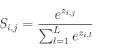
    
That might look daunting, but we can break it down into simple pieces and express it in Python
code, which you may find is more approachable than the formula above. To start, here are
example outputs from a neural network layer:
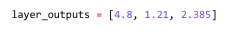

The first step for us is to “exponentiate” the outputs. We do this with Euler’s number, ​ e, ​ which is
roughly ​ 2.71828182846 ​ and referred to as the “exponential growth” number. Exponentiating is
taking this constant to the power of the given parameter:

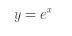
Both the numerator and the denominator of the Softmax function contain ​ e ​ raised to the power of
z ​ , where ​ z ​ , given indices, means a singular output value — the index ​ i ​ means the current sample
and the index ​ j ​ means the current output in this sample. The numerator exponentiates the current
output value and the denominator takes a sum of all of the exponentiated outputs for a given
sample. We need then to calculate these exponentiates to continue:

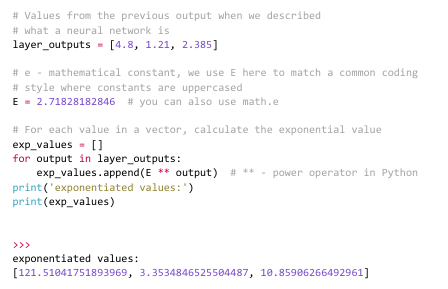
Exponentiation serves multiple purposes. To calculate the probabilities, we need non-negative
values. Imagine the output as ​ [ ​ 4.8​ , ​ 1.21​ , -​ 2.385​ ] ​ — even after normalization, the last
value will still be negative since we’ll just divide all of them by their sum. A negative probability
(or confidence) does not make much sense. An exponential value of any number is always
non-negative — it returns 0 for negative infinity, 1 for the input of 0, and increases for positive
values:
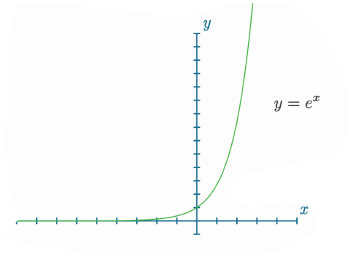
Figure 38: Graph of an exponential function.

The exponential function is a monotonic function. This means that, with higher input values,
outputs are also higher, so we won’t change the predicted class after applying it while making
sure that we get non-negative values. It also adds stability to the result as the normalized
exponentiation is more about the difference between numbers than their magnitudes. Once we’ve
exponentiated, we want to convert these numbers to a probability distribution (converting the
values into the vector of confidences, one for each class, which add up to 1 for everything in the
vector). What that means is that we’re about to perform a normalization where we take a given
value and divide it by the sum of all of the values. For our outputs, exponentiated at this stage,
that’s what the equation of the Softmax function describes next — to take a given exponentiated
value and divide it by the sum of all of the exponentiated values. Since each output value
normalizes to a fraction of the sum, all of the values are now in the range of 0 to 1 and add up to 1
— they share the probability of 1 between themselves. Let’s add the sum and normalization to the
code:
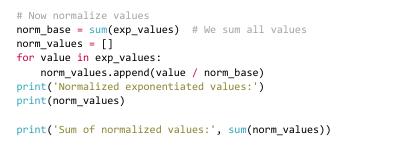

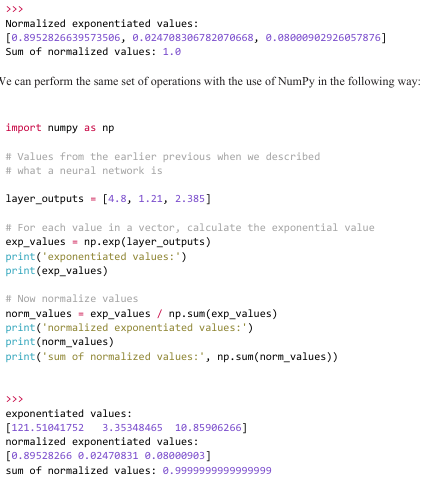

Notice the results are similar, but faster to calculate and the code is easier to read with NumPy.
We can exponentiate all of the values with a single call of the ​ np.exp()​ , then immediately
normalize them with the sum. To train in batches, we need to convert this functionality to accept
layer outputs in batches. Doing this is as easy as:
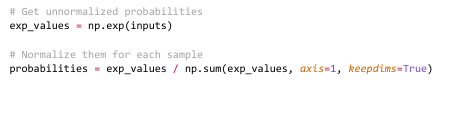
We have some new functions. Specifically, ​ np.exp()​ does the ​ E ​ **​ output​ part. We should
also address what ​ axis a ​ nd ​ keepdims m
ean in the above. Let’s first discuss the ​ axis ​ . Axis is
easier to show than tell, but, in a 2D array/matrix, axis 0 refers to the rows, and axis 1 refers to
the columns. Let’s see some examples of how ​ axis ​ affects the sum using NumPy. First, we
will just show the default, which is ​ None
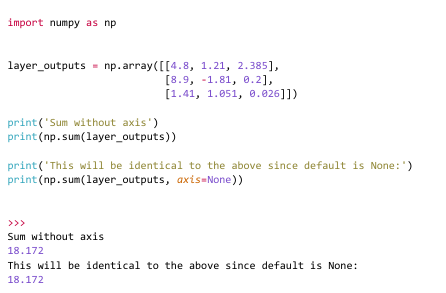

With no axis specified, we are just summing all of the values, even if they’re in varying
dimensions. Next, ​ axis =
​ 0 ​ . This means to sum row-wise, along axis 0. In other words, the output
has the same size as this axis, as at each of the positions of this output, the values from all the
other dimensions at this position are summed to form it. In the case of our 2D array, where we
have only a single other dimension, the columns, the output vector will sum these columns. This
means we’ll perform ​ 4.8+8.9+1.41 ​ and so on.

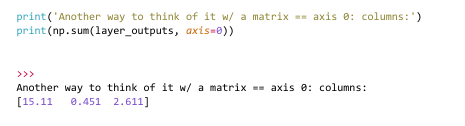

This isn’t what we want, though. We want sums of the rows. You can probably guess how to do
this with NumPy, but  look at this version:

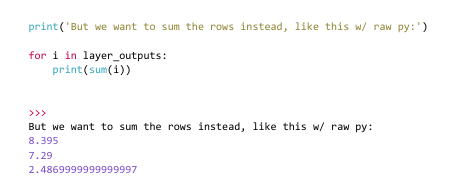

With the above, we could append these to some list in any way we want. That said, we’re going to
use NumPy. As you probably guessed, we’re going to sum along axis 1:
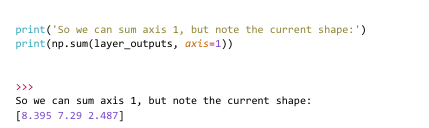

As pointed out by “​ note the current shape​ ,” we did get the sums that we expected, but
actually, we want to simplify the outputs to a single value per sample. We’re trying to sum all
the outputs from a layer for each sample in a batch; converting the layer’s output array with row
length equal to the number of neurons in the layer, to just one value. We need a column vector
with these values since it will let us normalize the whole batch of samples, sample-wise, with a
single calculation.

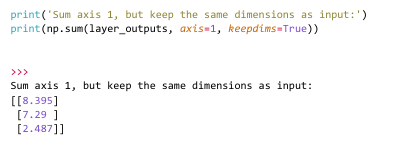

With this, we keep the same dimensions as the input. Now, if we divide the array containing a
batch of the outputs with this array, NumPy will perform this sample-wise. That means that it’ll
divide all of the values from each output row by the corresponding row from the sum array. Since
this sum in each row is a single value, it’ll be used for the division with every value from the
corresponding output row). We can combine all of this into a softmax class, like:

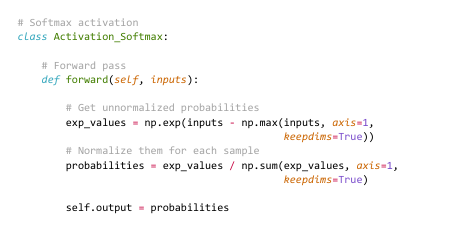

Finally, we also included a subtraction of the largest of the inputs before we did the
exponentiation. There are two main pervasive challenges with neural networks: “dead neurons”
and very large numbers (referred to as “exploding” values). “Dead” neurons and enormous
numbers can wreak havoc down the line and render a network useless over time. The exponential
function used in softmax activation is one of the sources of exploding values. Let’s see some
examples of how and why this can easily happen:

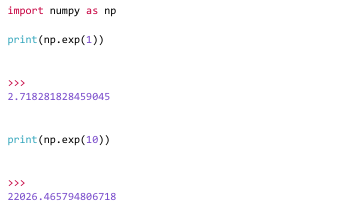

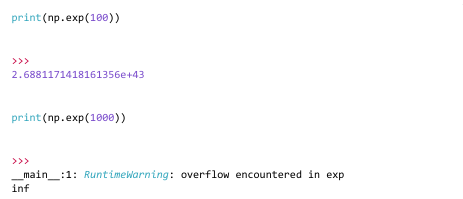

It doesn’t take a very large number, in this case, a mere ​ 1,000 , ​ to cause an overflow error. We
know the exponential function tends toward 0 as its input value approaches negative infinity, and
the output is 1 when the input is 0 (as shown in the chart earlier):

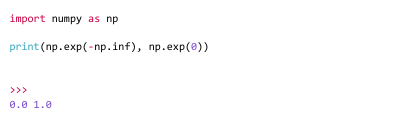

We can use this property to prevent the exponential function from overflowing. Suppose we
subtract the maximum value from a list of input values. We would then change the output values
to always be in a range from some negative value up to 0, as the largest number subtracted by
itself returns 0, and any smaller number subtracted by it will result in a negative number —
exactly the range discussed above. With Softmax, thanks to the normalization, we can subtract
any value from all of the inputs, and it will not change the output:

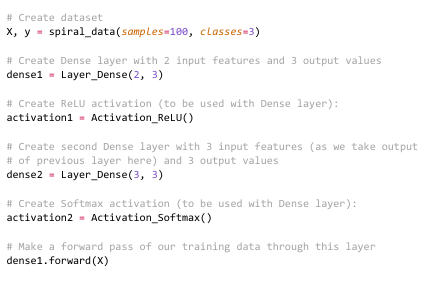

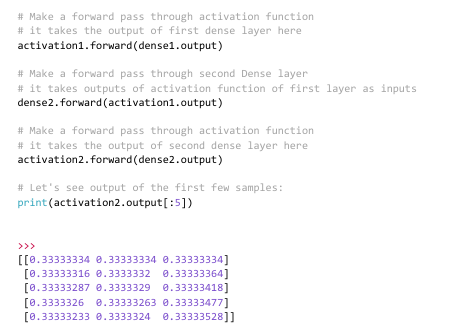

As you can see, the distribution of predictions is almost equal, as each of the samples has ~33%
(0.33) predictions for each class. This results from the random initialization of weights (a draw
from the normal distribution, as not every random initialization will result in this) and zeroed
biases. These outputs are also our “confidence scores.” To determine which classification the
model has chosen to be the prediction, we perform an ​ argmax ​ on these outputs, which checks
which of the classes in the output distribution has the highest confidence and returns its index -
the predicted class index. That said, the confidence score can be as important as the class
prediction itself. For example, the argmax of [
​ 0.22​ , ​ 0.6​ , ​ 0.18​ ] ​ i ​ s the same as the argmax for
[​ 0.32​ , ​ 0.36​ , ​ 0.32​ ] ​ . In both of these, the argmax function would return an index value of 1
(the 2nd element in Python’s zero-indexed paradigm), but obviously, a 60% confidence is much
better than a 36% confidence.


## Steps
###  spiral_data: 
A simple function that generates a 2D spiral dataset.
### Layer_Dense: 
A class that initializes weights and biases, then performs a forward pass by computing np.dot(inputs, weights) + biases.
### Activation_ReLU: 
Implements the ReLU activation by using np.maximum(0, inputs) to clip negative values to zero.
### Activation_Softmax: 
Applies the softmax function to the inputs, converting them into probabilities.


In [1]:
import numpy as np

# Function to create spiral data
def spiral_data(samples, classes):
    X = np.zeros((samples * classes, 2))  # Input features
    y = np.zeros(samples * classes, dtype='uint8')  # Class labels
    for class_number in range(classes):
        ix = range(samples * class_number, samples * (class_number + 1))
        r = np.linspace(0.0, 1, samples)  # Radius
        t = np.linspace(class_number * 4, (class_number + 1) * 4, samples) + np.random.randn(samples) * 0.2  # Theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = class_number
    return X, y

# Dense layer
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Calculate output values from inputs, weights, and biases
        self.output = np.dot(inputs, self.weights) + self.biases

# ReLU activation
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

# Softmax activation
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 3 input features (as we take output of previous layer here) and 3 output values
dense2 = Layer_Dense(3, 3)

# Create Softmax activation (to be used with Dense layer)
activation2 = Activation_Softmax()

# Make a forward pass of our training data through this layer
dense1.forward(X)

# Make a forward pass through activation function
activation1.forward(dense1.output)

# Make a forward pass through second Dense layer
dense2.forward(activation1.output)

# Make a forward pass through activation function
activation2.forward(dense2.output)

# Let's see output of the first few samples
print(activation2.output[:5])


[[0.33333333 0.33333333 0.33333333]
 [0.33333339 0.33333332 0.33333329]
 [0.33333375 0.33333328 0.33333297]
 [0.33333426 0.33333321 0.33333253]
 [0.33333397 0.33333325 0.33333278]]


We’ve completed what we need for forward-passing data through our model. We used the
Rectified Linear (ReLU​ ) activation function on the hidden layer, which works on a per-neuron
basis. We additionally used the ​ Softmax​ activation function for the output layer since it accepts
non-normalized values as input and outputs a probability distribution, which we’re using as
confidence scores for each class. Recall that, although neurons are interconnected, they each have
their respective weights and biases and are not “normalized” with each other.

Next ------->​ loss function​ .

## Calculating Network Error with Loss

With a randomly-initialized model, or even a model initialized with more sophisticated
approaches, our goal is to train, or teach, a model over time. To train a model, we tweak the
weights and biases to improve the model’s accuracy and confidence. To do this, we calculate how
much error the model has. The ​ loss function​ , also referred to as the ​ cost function​ , is the
algorithm that quantifies how wrong a model is. ​ Loss​ is the measure of this metric. Since loss is
the model’s error, we ideally want it to be 0.
You may wonder why we do not calculate the error of a model based on the argmax accuracy.
Recall our earlier example of confidence: ​ [ ​ 0.22​ , ​ 0.6​ , ​ 0.18​ ] ​ vs ​ [ ​ 0.32​ , ​ 0.36​ , ​ 0.32​ ] ​ .
If the correct class were indeed the middle one (index 1), the model accuracy would be identical
between the two above. But are these two examples ​ really ​ as accurate as each other? They are
not, because accuracy is simply applying an argmax to the output to find the index of the
biggest value. The output of a neural network is actually confidence, and more confidence inChapter 5 - Calculating Network Error with Loss - Neural Networks from Scratch in Python
7
the correct answer is better. Because of this, we strive to increase correct confidence and
decrease misplaced confidence.

## Categorical Cross-Entropy Loss
If you’re familiar with linear regression, then you already know one of the loss functions used
with neural networks that do regression: ​ squared error​ (or ​ mean squared error​ w
ith neural
networks).
We’re not performing regression in this example; we’re classifying, so we need a different loss
function. The model has a softmax activation function for the output layer, which means it’s
outputting a probability distribution. ​ Categorical cross-entropy​ is explicitly used to compare
a “ground-truth” probability (​ y o ​ r​ “ ​ ​ targets ” ​ ) and some predicted distribution (​ y-hat o ​ r
“​ predictions ​ ”), so it makes sense to use cross-entropy here. It is also one of the most
commonly used loss functions with a softmax activation on the output layer.
The formula for calculating the categorical cross-entropy of ​ y ​ (actual/desired distribution) and
y-hat ​ (predicted distribution) is:
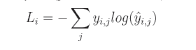

Where ​ L ​ i ​ denotes sample loss value, ​ i ​ is the i-th sample in the set, ​ j ​ is the label/output index, ​ y
denotes the target values, and ​ y-hat ​ denotes the predicted values.
Once we start coding the solution, we’ll simplify it further to -​ log(correct_class_confidence) , ​ the
formula for which is:

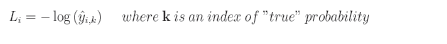

Where ​ L ​ i ​ denotes sample loss value, ​ i ​ is the i-th sample in a set, ​ k ​ is the index of the target label
(ground-true label), ​ y ​ denotes the target values and ​ y-hat ​ denotes the predicted values.

You may ask why we call this cross-entropy and not ​ log loss​ , which is also a type of loss. If you
do not know what log loss is, you may wonder why there is such a fancy looking formula for
what looks to be a fairly basic description.
In general, the log loss error function is what we apply to the output of a binary logistic regression
model (which we’ll describe in chapter 16) — there are only two classes in the distribution, each
of them applying to a single output (neuron) which is targeted as a 0 or 1. In our case, we have a
classification model that returns a probability distribution over all of the outputs. Cross-entropy
compares two probability distributions. In our case, we have a softmax output, let’s say it’s:

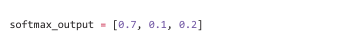

Which probability distribution do we intend to compare this to? We have 3 class confidences in
the above output, and let’s assume that the desired prediction is the first class (index 0, which is
currently 0.7). If that’s the intended prediction, then the desired probability distribution is ​ [ ​ 1 ​ ,
0​ , ​ 0 ​ ] ​ . Cross-entropy can also work on probability distributions like ​ [ ​ 0.2​ , ​ 0.5​ , ​ 0.3​ ] ​ ; they
wouldn’t have to look like the one above. That said, the desired probabilities will consist of a 1
in the desired class, and a 0 in the remaining undesired classes. Arrays or vectors like this are
called ​ one-hot​ , ​ meaning one of the values is “hot” (on), with a value of 1, and the rest are
“cold” (off), with values of 0. When comparing the model’s results to a one-hot vector using
cross-entropy, the other parts of the equation zero out, and the target probability’s log loss is
multiplied by 1, making the cross-entropy calculation relatively simple. This is also a special
case of the cross-entropy calculation, called categorical cross-entropy. To exemplify this — if
we take a softmax output of ​ [ ​ 0.7​ , ​ 0.1​ , ​ 0.2​ ] ​ and targets of ​ [ ​ 1 ​ , ​ 0 ​ , ​ 0 ​ ] ​ , we can apply the
calculations as follows:

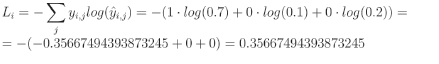

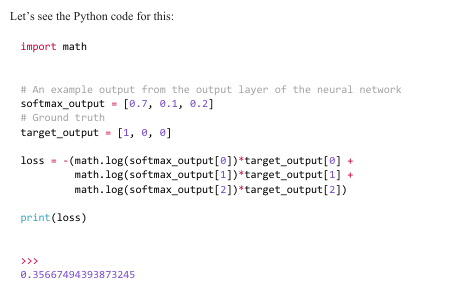

That’s the full categorical cross-entropy calculation, but we can make a few assumptions given
one-hot target vectors. First, what are the values for ​ target_output[​ 1 ​ ] ​ ​ and
target_output[​ 2 ​ ] ​ in this case? They’re both 0, and anything multiplied by 0 is 0. Thus, we
don’t need to calculate these indices. Next, what’s the value for ​ target_output[​ 0 ​ ] ​ ​ in this
case? It’s 1. So this can be omitted as any number multiplied by 1 remains the same. The same
output then, in this example, can be calculated with:
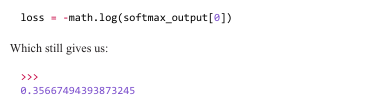

As you can see with one-hot vector targets, or scalar values that represent them, we can make
some simple assumptions and use a more basic calculation — what was once an involved formula
reduces to the negative log of the target class’ confidence score — the second formula presented
at the beginning of this chapter.
As we’ve already discussed, the example confidence level might look like ​ [ ​ 0.22​ , ​ 0.6​ , ​ 0.18​ ]
or ​ [ ​ 0.32​ , ​ 0.36​ , ​ 0.32​ ] ​ . In both cases, the ​ argmax ​ of these vectors will return the second
class as the prediction, but the model’s confidence about these predictions is high only for one of
them. The ​ Categorical Cross-Entropy Loss​ accounts for that and outputs a larger loss the lower
the confidence is

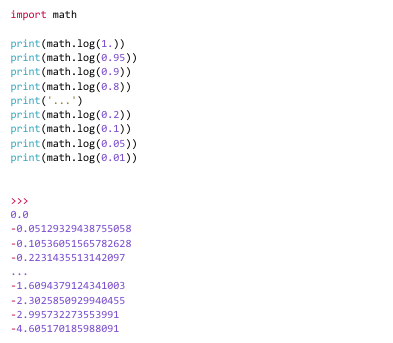

We’ve printed different log values for a few example confidences. When the confidence level
equals ​ 1 , ​ meaning the model is 100% “sure” about its prediction, the loss value for this sample
equals ​ 0 . ​ The loss value raises with the confidence level, approaching 0. You might also wonder
why we did not print the result of ​ log(0) ​ — we’ll explain that shortly.
So far, we’ve applied log() to the softmax output, but have neither explained what “log” is nor
why we use it. We will save the discussion of “why” until the next chapter, which covers
derivatives, gradients, and optimizations; suffice it to say that the log function has some desirable
properties. ​ Log​ is short for ​ logarithm ​ and is defined as the solution for the x-term in an equation
of the form a​ x ​ = b. For example, ​ 10 ​ x =
100 ​ can be solved with a log: ​ log 10
(100)
, ​ which evaluates to
2. This property of the log function is ​ especially ​ beneficial when ​ e ( ​ Euler’s number or ​ ~2.71828 ) ​
is used in the base (where 10 is in the example). The logarithm with ​ e a ​ s its base is referred to as
the ​ natural logarithm​ , ​ natural log​ , or simply ​ log​ — you may also see this written as ​ ln​ : ​ ln(x) =
log(x) = log e ​ (x)
The variety of conventions can make this confusing, so to simplify things, ​ any
mention of log will always be a natural logarithm throughout this book​ . The natural log
represents the solution for the x-term in the equation ​ e x ​ =
b ; ​ for example, ​ e x ​ =
5.2 ​ is solved by
log(5.2) ​ .
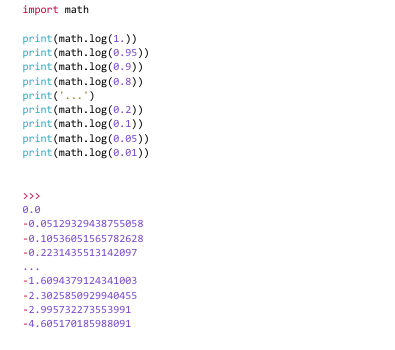

We’ve printed different log values for a few example confidences. When the confidence level
equals ​ 1 , ​ meaning the model is 100% “sure” about its prediction, the loss value for this sample
equals ​ 0 . ​ The loss value raises with the confidence level, approaching 0. You might also wonder
why we did not print the result of ​ log(0) ​ — we’ll explain that shortly.
So far, we’ve applied log() to the softmax output, but have neither explained what “log” is nor
why we use it. We will save the discussion of “why” until the next chapter, which covers
derivatives, gradients, and optimizations; suffice it to say that the log function has some desirable
properties. ​ Log​ is short for ​ logarithm ​ and is defined as the solution for the x-term in an equation
of the form a​ x ​ = b. For example, ​ 10 ​ x =
100 ​ can be solved with a log: ​ log 10
(100)
, ​ which evaluates to
2. This property of the log function is ​ especially ​ beneficial when ​ e ( ​ Euler’s number or ​ ~2.71828 ) ​
is used in the base (where 10 is in the example). The logarithm with ​ e a ​ s its base is referred to as
the ​ natural logarithm​ , ​ natural log​ , or simply ​ log​ — you may also see this written as ​ ln​ : ​ ln(x) =
log(x) = log e ​ (x)
The variety of conventions can make this confusing, so to simplify things, ​ any
mention of log will always be a natural logarithm throughout this book​ . The natural log
represents the solution for the x-term in the equation ​ e x ​ =
b ; ​ for example, ​ e x ​ =
5.2 ​ is solved by
log(5.2) ​ .We’ve printed different log values for a few example confidences. When the confidence level
equals ​ 1 , ​ meaning the model is 100% “sure” about its prediction, the loss value for this sample
equals ​ 0 . ​ The loss value raises with the confidence level, approaching 0. You might also wonder
why we did not print the result of ​ log(0) ​ — we’ll explain that shortly.
So far, we’ve applied log() to the softmax output, but have neither explained what “log” is nor
why we use it. We will save the discussion of “why” until the next chapter, which covers
derivatives, gradients, and optimizations; suffice it to say that the log function has some desirable
properties. ​ Log​ is short for ​ logarithm ​ and is defined as the solution for the x-term in an equation
of the form a​ x ​ = b. For example, ​ 10 ​ x =
100 ​ can be solved with a log: ​ log 10
(100)
, ​ which evaluates to
2. This property of the log function is ​ especially ​ beneficial when ​ e ( ​ Euler’s number or ​ ~2.71828 ) ​
is used in the base (where 10 is in the example). The logarithm with ​ e a ​ s its base is referred to as
the ​ natural logarithm​ , ​ natural log​ , or simply ​ log​ — you may also see this written as ​ ln​ : ​ ln(x) =
log(x) = log e ​ (x)
The variety of conventions can make this confusing, so to simplify things, ​ any
mention of log will always be a natural logarithm throughout this book​ . The natural log
represents the solution for the x-term in the equation ​ e x ​ =
b ; ​ for example, ​ e x ​ =
5.2 ​ is solved by
log(5.2) ​ .

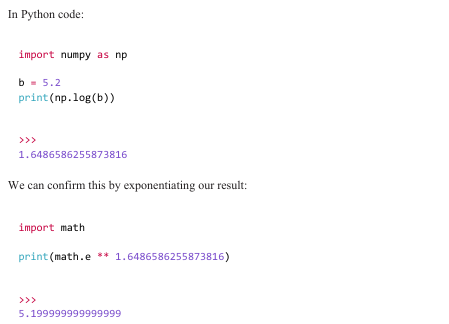

The small difference is the result of floating-point precision in Python. Getting back to the loss
calculation, we need to modify our output in two additional ways. First, we’ll update our process
to work on batches of softmax output distributions; and second, make the negative log calculation
dynamic to the target index (the target index has been hard-coded so far).
Consider a scenario with a neural network that performs classification between three classes, and
the neural network classifies in batches of three. After running through the softmax activation
function with a batch of 3 samples and 3 classes, the network’s output layer yields:

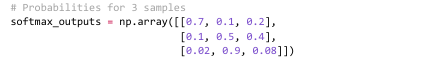

We need a way to dynamically calculate the categorical cross-entropy, which we now know is a
negative log calculation. To determine which value in the softmax output to calculate the negative
log from, we simply need to know our target values. In this example, there are 3 classes; let’s say
we’re trying to classify something as a “dog,” “cat,” or “human.” A dog is class 0 (at index 0), a
cat class 1 (index 1), and a human class 2 (index 2). Let’s assume the batch of three sample inputs
to this neural network is being mapped to the target values of a dog, cat, and cat. So the targets (as a list of target indices) would be ​ [0, 1, 1] ​ .

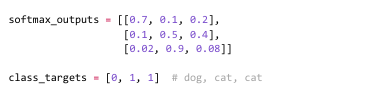

The first value, 0, in ​ class_targets​ means the first softmax output distribution’s intended
prediction was the one at the 0th index of ​ [ ​ 0.7​ , ​ 0.1​ , ​ 0.2​ ] ​ ; the model has a ​ 0.7​ confidence
score that this observation is a dog. This continues throughout the batch, where the intended target
of the 2nd softmax distribution, ​ [ ​ 0.1​ , ​ 0.5​ , ​ 0.4​ ] ​ , was at an index of 1; the model only has a
0.5​ confidence score that this is a cat — the model is less certain about this observation. In the
last sample, it’s also the 2nd index from the softmax distribution, a value of ​ 0.9​ in this case — a
pretty high confidence.
With a collection of softmax outputs and their intended targets, we can map these indices to
retrieve the values from the softmax distributions:

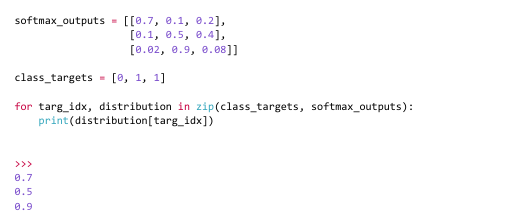
The ​ zip​ ()​ function, again, lets us iterate over multiple iterables at the same time in Python. This
can be further simplified using NumPy (we’re creating a NumPy array of the Softmax outputs this
time):
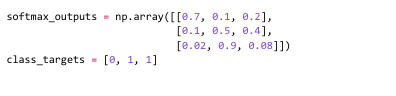
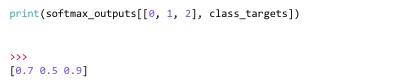

What are the 0, 1, and 2 values? NumPy lets us index an array in multiple ways. One of them is to
use a list filled with indices and that’s convenient for us — we could use the ​ class_targets​ for
this purpose as it already contains the list of indices that we are interested in. The problem is that
this has to filter data rows in the array — the second dimension. To perform that, we also need to
explicitly filter this array in its first dimension. This dimension contains the predictions and we, of
course, want to retain them all. We can achieve that by using a list containing numbers from 0
through all of the indices. We know we’re going to have as many indices as distributions in our
entire batch, so we can use a ​ range​ ()​ instead of typing each value ourselves:

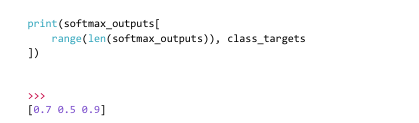

This returns a list of the confidences at the target indices for each of the samples. Now we apply
the negative log to this list:

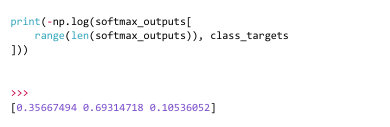

Finally, we want an average loss per batch to have an idea about how our model is doing during
training. There are many ways to calculate an average in Python; the most basic form of an
average is the ​ arithmetic mean​ : ​ sum(iterable) / len(iterable) ​ . NumPy has a method that
computes this average on arrays, so we will use that instead. We add NumPy’s average to the
code:
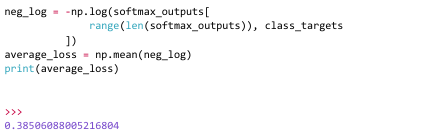

We have already learned that targets can be one-hot encoded, where all values, except for one, are
zeros, and the correct label’s position is filled with 1. They can also be sparse, which means that
the numbers they contain are the correct class numbers — we are generating them this way with
the ​ spiral_data​ ()​ function, and we can allow the loss calculation to accept any of these forms.
Since we implemented this to work with sparse labels (as in our training data), we have to add a
check if they are one-hot encoded and handle it a bit differently in this new case. The check can
be performed by counting the dimensions — if targets are single-dimensional (like a list), they are
sparse, but if there are 2 dimensions (like a list of lists), then there is a set of one-hot encoded
vectors. In this second case, we’ll implement a solution using the first equation from this chapter,
instead of filtering out the confidences at the target labels. We have to multiply confidences by
the targets, zeroing out all values except the ones at correct labels, performing a sum along the
row axis (axis ​ 1 ) ​ . We have to add a test to the code we just wrote for the number of dimensions,
move calculations of the log values outside of this new ​ if ​ statement, and implement the solution
for the one-hot encoded labels following the first equation:We have already learned that targets can be one-hot encoded, where all values, except for one, are
zeros, and the correct label’s position is filled with 1. They can also be sparse, which means that
the numbers they contain are the correct class numbers — we are generating them this way with
the ​ spiral_data​ ()​ function, and we can allow the loss calculation to accept any of these forms.
Since we implemented this to work with sparse labels (as in our training data), we have to add a
check if they are one-hot encoded and handle it a bit differently in this new case. The check can
be performed by counting the dimensions — if targets are single-dimensional (like a list), they are
sparse, but if there are 2 dimensions (like a list of lists), then there is a set of one-hot encoded
vectors. In this second case, we’ll implement a solution using the first equation from this chapter,
instead of filtering out the confidences at the target labels. We have to multiply confidences by
the targets, zeroing out all values except the ones at correct labels, performing a sum along the
row axis (axis ​ 1 ) ​ . We have to add a test to the code we just wrote for the number of dimensions,
move calculations of the log values outside of this new ​ if ​ statement, and implement the solution
for the one-hot encoded labels following the first equation:

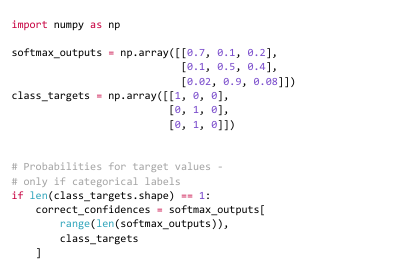
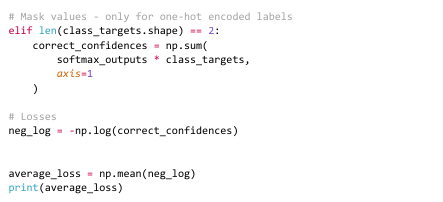

Before we move on, there is one additional problem to solve. The softmax output, which is also
an input to this loss function, consists of numbers in the range from 0 to 1 - a list of confidences.
It is possible that the model will have full confidence for one label making all the remaining
confidences zero. Similarly, it is also possible that the model will assign full confidence to a value
that wasn’t the target. If we then try to calculate the loss of this confidence of 0:
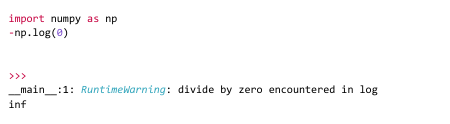

Before we explain this, we need to talk about ​ log(0) ​ . From the mathematical point of view, ​ log(0)
is undefined. We already know the following dependence: if ​ y=log(x) , ​ then ​ e ​ y ​ =x ​ . The question of
what the resulting ​ y ​ is in ​ y=log(0) ​ is the same as the question of what’s the ​ y ​ in ​ e ​ y ​ =0 ​ . In
simplified terms, the constant ​ e ​ to any power is always a positive number, and there is no ​ y
resulting in ​ e ​ y =0
. ​ This means the ​ log(0) ​ is undefined. We need to be aware of what the ​ log(0) ​ is,
and “undefined” does not mean that we don’t know anything about it. Since ​ log(0) ​ is undefined,
what’s the result for a value very close to ​ 0 ? ​ We can calculate the limit of a function. How to
exactly calculate it exceeds this book, but the solution is:

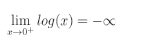

We read it as the limit of a natural logarithm of ​ x , ​ with x approaching ​ 0 ​ from a positive (it is impossible to calculate the natural logarithm of a negative value) equals negative infinity. What
this means is that the limit is negative infinity for an infinitely small ​ x , ​ where ​ x ​ never reaches ​ 0 . ​
The situation is a bit different in programming languages. We do not have limits here, just a
function which, given a parameter, returns some value. The negative natural logarithm of ​ 0 , ​ in
Python with NumPy, equals an infinitely big number, rather than undefined, and prints a warning
about a division by ​ 0 ​ (which is a result of how this calculation is done). If -​ np.log(​ 0 ​ ) ​ equals
inf​ , is it possible to calculate e to the power of negative infinity with Python?

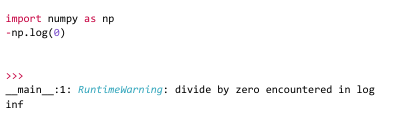

We could add a very small value to the confidence to prevent it from being a zero, for example,
1e-7 ​ :

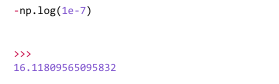

Adding a very small value, one-tenth of a million, to the confidence at its far edge will
insignificantly impact the result, but this method yields an additional 2 issues. First, in the
case where the confidence value is ​ 1 ​ :

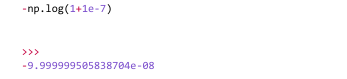

When the model is fully correct in a prediction and puts all the confidence in the correct label,
loss becomes a negative value instead of being 0. The other problem here is shifting confidence
towards ​ 1 , ​ even if by a very small value. To prevent both issues, it’s better to clip values from
both sides by the same number, ​ 1e-7 ​ in our case. That means that the lowest possible value will
become ​ 1e-7 ​ (like in the demonstration we just performed) but the highest possible value, instead
of being ​ 1+1e-7 ​ , will become ​ 1-1e-7 ​ (so slightly less than ​ 1 ​ ):

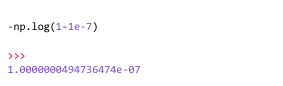

This will prevent loss from being exactly ​ 0 ​ , making it a very small value instead, but won’t make
it a negative value and won’t bias overall loss towards ​ 1 . ​ Within our code and using numpy, we’ll
accomplish that using ​ np.clip()​ method:

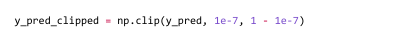

This method can perform clipping on an array of values, so we can apply it to the predictions
directly and save this as a separate array, which we’ll use shortly.



